# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [22]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
from typing import Callable, Union, NoReturn, Optional, Dict, Any, List

## Задание 1 (1 балл)

Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [2]:
def get_props(x: np.ndarray):
    """
    Считает пропорции
    """
    tmp = np.unique(x, return_counts=True)
    return tmp[1] / x.shape[0]


def gini(x: np.ndarray) -> float:
    """
    Считает коэффициент Джини для массива меток x.
    """
    props = get_props(x)
    return np.sum(props * (1 - props))
    
def entropy(x: np.ndarray) -> float:
    """
    Считает энтропию для массива меток x.
    """
    props = get_props(x)
    return -np.sum(props * np.log(props))

def gain(left_y: np.ndarray, right_y: np.ndarray, criterion: Callable) -> float:
    """
    Считает информативность разбиения массива меток.

    Parameters
    ----------
    left_y : np.ndarray
        Левая часть разбиения.
    right_y : np.ndarray
        Правая часть разбиения.
    criterion : Callable
        Критерий разбиения.
    """
    left_size = left_y.shape[0]
    right_size = right_y.shape[0]
    common_size = left_size + right_size
    return common_size * criterion(np.hstack((left_y, right_y))) - left_size * criterion(left_y) - right_size * criterion(right_y)

## Задание 2 (1 балл)

Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбираем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__ (например, для вычисления вероятности в следующем задании)

In [3]:
class DecisionTreeLeaf:
    def __init__(self, y):
        unique_y, freq = np.unique(y, return_counts=True)
        self.y = unique_y[np.argmax(freq)]
        self.y_to_prob = dict(zip(unique_y, freq / y.shape[0]))

class DecisionTreeNode:
    def __init__(self, split_dim, split_value, left, right):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right

## Задание 3 (6 баллов)

Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`. Вероятности классов в листе можно определить через количество объектов соответствующего класса в листе. 

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [4]:
class DecisionTreeClassifier:
    """
    Attributes
    ----------
    root : Union[DecisionTreeNode, DecisionTreeLeaf]
        Корень дерева.

    (можете добавлять в класс другие аттрибуты).

    """
    def __init__(self, criterion : str = "gini",
                 max_depth : Optional[int] = None,
                 min_samples_leaf: int = 1):
        """
        Parameters
        ----------
        criterion : str
            Задает критерий, который будет использоваться при построении дерева.
            Возможные значения: "gini", "entropy".
        max_depth : Optional[int]
            Ограничение глубины дерева. Если None - глубина не ограничена.
        min_samples_leaf : int
            Минимальное количество элементов в каждом листе дерева.

        """
        self.root = None
        self.max_depth = 30 if max_depth is None else max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_gain = 1.0e-5
        if criterion == "gini":
            self.criterion = gini
        elif criterion == "entropy":
            self.criterion = entropy
        else:
            raise NotImplementedError


    def _gain_dim(self, X, y, dim: int):
        objects_count = X.shape[0]
        values_by_dim = X.T[dim]
        sort_idx = np.argsort(values_by_dim)

        values_by_dim = values_by_dim[sort_idx]
        y = y[sort_idx]

        best_split_value = values_by_dim[0]
        max_gain = gain(left_y=y[:(0 + 1)], right_y=y[(0 + 1):], criterion=self.criterion) #TODO
        for object_idx in range(objects_count - 1):
            split_value = (values_by_dim[object_idx] + values_by_dim[object_idx + 1]) / 2
            cur_gain = gain(left_y=y[:(object_idx + 1)], right_y=y[(object_idx + 1):], criterion=self.criterion)
            if cur_gain > max_gain:
                max_gain = cur_gain
                best_split_value = split_value

        return max_gain, best_split_value


    def _split_nodes_by_feature(self, X: np.ndarray, y: np.ndarray, dim: int, split_value):
        values_by_dim = X.T[dim]
        left_idx = values_by_dim < split_value
        right_idx = ~left_idx
        return X[left_idx], y[left_idx], X[right_idx], y[right_idx]


    def _build_tree(self, X: np.ndarray, y: np.ndarray, depth: int) -> Union[DecisionTreeNode, DecisionTreeLeaf]:
        if depth == self.max_depth or y.shape[0] <= self.min_samples_leaf:
            return DecisionTreeLeaf(y)
        max_gain = float('-inf')
        split_value_of_max = 0
        dim_of_max = 0
        for dim_idx in range(self.dimension_count):
            cur_gain, split_value = self._gain_dim(X, y, dim_idx)
            if cur_gain > max_gain:
                max_gain, split_value_of_max, dim_of_max = cur_gain, split_value, dim_idx
        # split into children nodes
        left_X, left_y, right_X, right_y = self._split_nodes_by_feature(X, y, dim_of_max, split_value_of_max)
        # if we cannot split nodes
        if left_y.shape[0] == 0 or right_y.shape[0] == 0:
            return DecisionTreeLeaf(y)

        left_node = self._build_tree(left_X, left_y, depth + 1)
        right_node = self._build_tree(right_X, right_y, depth + 1)

        return DecisionTreeNode(split_dim=dim_of_max, split_value=split_value_of_max, left=left_node, right=right_node)


    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        """
        Строит дерево решений по обучающей выборке.

        Parameters
        ----------
        X : np.ndarray
            Обучающая выборка.
        y : np.ndarray
            Вектор меток классов.
        """
        self.dimension_count = X.shape[1]
        self.root = self._build_tree(X, y, depth=0)


    def _search_leaf(self, x, list_splits=None) -> Union[DecisionTreeNode, DecisionTreeLeaf]:
        node = self.root
        while isinstance(node, DecisionTreeNode):
            if list_splits is not None:
                list_splits.append((node.split_dim, node.split_value))
            if x[node.split_dim] < node.split_value:
                node = node.left
            else:
                node = node.right
        return node


    def get_path(self, x):
        list_splits = []
        leaf = self._search_leaf(x, list_splits)
        p = leaf.y_to_prob
        return max(p.keys(), key=lambda k: p[k]), list_splits


    def _predict_proba_point(self, x):
        # go to the leaf
        leaf = self._search_leaf(x)
        return leaf.y_to_prob


    def predict_proba(self, X: np.ndarray) ->  List[Dict[Any, float]]:
        """
        Предсказывает вероятность классов для элементов из X.

        Parameters
        ----------
        X : np.ndarray
            Элементы для предсказания.

        Return
        ------
        List[Dict[Any, float]]
            Для каждого элемента из X возвращает словарь
            {метка класса -> вероятность класса}.
        """
        return list(map(self._predict_proba_point, X))

    def predict(self, X : np.ndarray) -> list:
        """
        Предсказывает классы для элементов X.

        Parameters
        ----------
        X : np.ndarray
            Элементы для предсказания.

        Return
        ------
        list
            Вектор предсказанных меток для элементов X.
        """
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

In [5]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%i] < %f" % (tree_root.split_dim, tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [6]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Задание 4 (2 балла)

Протестируйте решение на датасете spam.
Для этой задачи используйте данные x_spam_train и y_spam_train:
1. Выполните загрузку и предобработку файлов x_spam_train и y_spam_train.
2. Разбейте x_spam_train и y_spam_train на x_train, y_train, x_test и y_test для оценки точности работы алгоритма.
3. Посчитайте метрики `precision`, `recall`, `accuracy` для модели Decision Tree. Если необходимо, попробуйте разные наборы параметров для получения лучшего результата.
4. Сравните значения метрик с результатами модели kNN из предыдущего задания (можно использовать реализацию из библиотеки `sklearn`).
5. Ответьте на следующие вопросы:
    - Какой нужен препроцессинг данных для моделей?
    - Какая модель делает предсказания лучше?  Предположите, почему.

_Ваш ответ:_ из датасета `x_spam_train/x_spam_test` на этапе препроцессинга стоило удалить абсолютно неинформативный признак `Id`. Обе модели работают примерно одинаково. Это происходит, скорее всего, потому что таргет равен 0 или 1 в зависимости от расположения точек друг относительно друга. `kNN` это делает по построению модели, а `decision tree` отбирает фичи/границы и создаваёт тем самым бакет, близких друг к другу точек. 

In [54]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

from sklearn.neighbors import KNeighborsClassifier

In [55]:
def get_precision_recall_accuracy(y_pred, y_true):
    classes = np.unique(list(y_train) + list(y_true))
    precisions = [precision_score(y_pred, y_true, pos_label=cls) for cls in classes]
    recalls = [recall_score(y_pred, y_true, pos_label=cls) for cls in classes]
    accuracies = [accuracy_score(y_pred, y_true) for cls in classes]
    return precisions, recalls, accuracies

In [14]:
def read_dataset_X_spam(path_to_csv):
    df = pd.read_csv(path_to_csv, sep=',')
    return np.array(df.drop('Id', 1))

In [37]:
def read_datasets_spam(path_to_x, path_to_y):
    X = read_dataset_X_spam(path_to_x)
    y_df = pd.read_csv(path_to_y, sep=',')
    y = np.array(y_df['Expected'])
    shuffle_idx = np.arange(y.shape[0])
    np.random.shuffle(shuffle_idx)
    
    X = X[shuffle_idx]
    y = y[shuffle_idx]
    return X, y

In [38]:
def train_test_split(X, y, ratio):
    # Возвращает X_train, y_train, X_test, y_test
    # X_train и X_test - массив векторов - две части массива X, разделенного в состветсви с коэффициентом ratio
    # y_train и y_test - соответствующие X_train и X_test метки классов
    size_train = (int)(np.size(X, axis=0) * ratio)
    
    X_train = X[: size_train]
    y_train = y[: size_train]
    
    X_test = X[size_train :]
    y_test = y[size_train : ]

    return X_train, y_train, X_test, y_test

In [62]:
path_to_spam_X = '/home/ivankozlov98/Learning/Bio_ML/Homeworks/Hw1/hw1/ml-intro/hw_dt_data/x_spam_train.csv'
path_to_spam_y = '/home/ivankozlov98/Learning/Bio_ML/Homeworks/Hw1/hw1/ml-intro/hw_dt_data/y_spam_train.csv'
X_train, y_train = read_datasets_spam(path_to_spam_X, path_to_spam_y)
X_train, y_train, X_test, y_test = train_test_split(X_train, y_train, ratio=0.8)

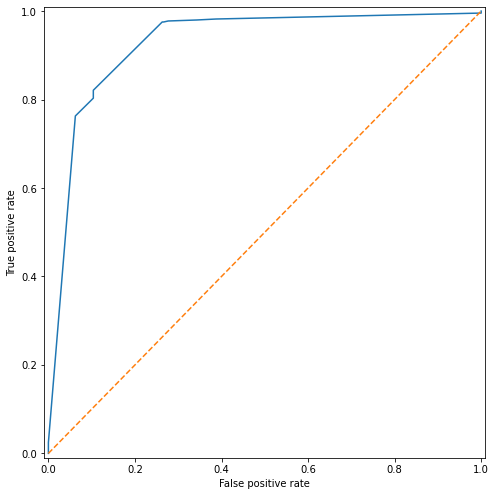

In [51]:
tree = DecisionTreeClassifier(max_depth=10, min_samples_leaf=30)
tree.fit(X_train, y_train)
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)

In [52]:
draw_tree(tree)

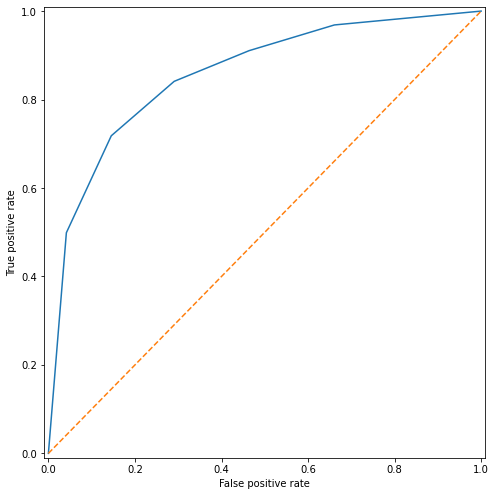

In [61]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)
neigh_predict_proba = list(map(lambda arr: dict(zip(np.arange(arr.shape[0]), arr)), neigh.predict_proba(X_test)))
plot_roc_curve(y_test, neigh_predict_proba)

In [65]:
y_pred_tree = tree.predict(X_test)
precisions, recalls, accuracies = get_precision_recall_accuracy(y_pred_tree, y_test)
print("Tree:")
print("Precisions:", precisions)
print("Recalls:", recalls)
print("Accuracies:", accuracies)

Tree:
Precisions: [0.9703196347031964, 0.7449664429530202]
Recalls: [0.8483033932135728, 0.9446808510638298]
Accuracies: [0.8790760869565217, 0.8790760869565217]


In [67]:
y_pred_knn = neigh.predict(X_test)
precisions, recalls, accuracies = get_precision_recall_accuracy(y_pred_knn, y_test)
print("kNN:")
print("Precisions:", precisions)
print("Recalls:", recalls)
print("Accuracies:", accuracies)

kNN:
Precisions: [0.8835616438356164, 0.8053691275167785]
Recalls: [0.8696629213483146, 0.8247422680412371]
Accuracies: [0.8519021739130435, 0.8519021739130435]


1. Обучите модель на всех данных из x_spam_train и y_spam_train.
2. Сделайте submit своего решения и получите значение f1_score не менее 0.6

In [68]:
X_train, y_train = read_datasets_spam(path_to_spam_X, path_to_spam_y)
path_to_X_test = '/home/ivankozlov98/Learning/Bio_ML/Homeworks/Hw1/hw1/ml-intro/hw_dt_data/x_spam_test.csv'
X_test = read_dataset_X_spam(path_to_X_test)

In [69]:
tree = DecisionTreeClassifier(max_depth=10, min_samples_leaf=30)
tree.fit(X_train, y_train)

In [72]:
submission = pd.DataFrame(columns = ["Id", "Expected"])
submission["Id"] = np.arange(X_test.shape[0])
submission["Expected"] = tree.predict(X_test)
submission.to_csv('submission.csv', index=False)
